20180634_최준혁_과제4

2.   (4  points)  Assume  the  local  linear  trend  model  for  Boston's  monthly  temperature data uploaded in the class website.   Plot the Kalman filter and smoother for the data (Use either Python or EViews; see https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_local_linear_trend.html for  the  Python  code).

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from pandas import read_excel
from pykalman import KalmanFilter
import statsmodels
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

# matplotlib 시각화 결과를 jupyter notebook에서 바로 볼 수 있게 해주는 command
%matplotlib inline

In [2]:
excel_data= read_excel('Boston.xlsx')
df = excel_data.copy()
df.set_index('DATE', inplace=True)
df

,TAVG
DATE,
1980-01-01,-1.44
1980-02-01,-2.33
1980-03-01,2.68
1980-04-01,9.29
1980-05-01,15.22
...,...
2019-02-01,0.90
2019-03-01,3.95
2019-04-01,10.94


<AxesSubplot:xlabel='DATE'>

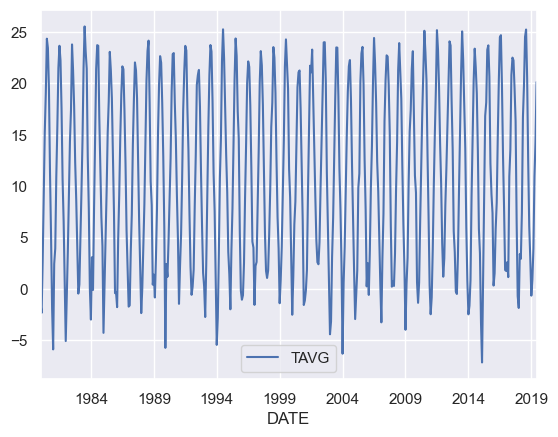

In [3]:
df.plot()

### Kalman Filter and Smoother

In [4]:
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [5]:
# Load Dataset

# Log transform
df['lTAVG'] = np.log(df['TAVG'])

# Setup the model
mod = LocalLinearTrend(df['TAVG'])

# Fit it using MLE (recall that we are fitting the three variance parameters)
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                   TAVG   No. Observations:                  474
Model:               LocalLinearTrend   Log Likelihood               -1327.934
Date:                Wed, 09 Nov 2022   AIC                           2661.867
Time:                        19:41:40   BIC                           2674.338
Sample:                    01-01-1980   HQIC                          2666.773
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.6657      0.825      0.807      0.420      -0.951       2.282
sigma2.level        6.804e-10      3.262   2.09e-10      1.000      -6.394       6.394
sigma2.trend        

In [6]:
predict = res.get_prediction()
forecast = res.get_forecast('9-1-2019')

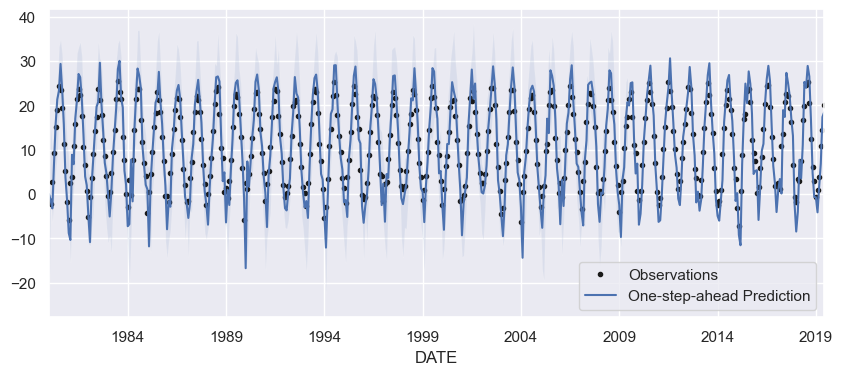

In [7]:
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
df['TAVG'].plot(ax=ax, style='k.', label='Observations')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

legend = ax.legend();

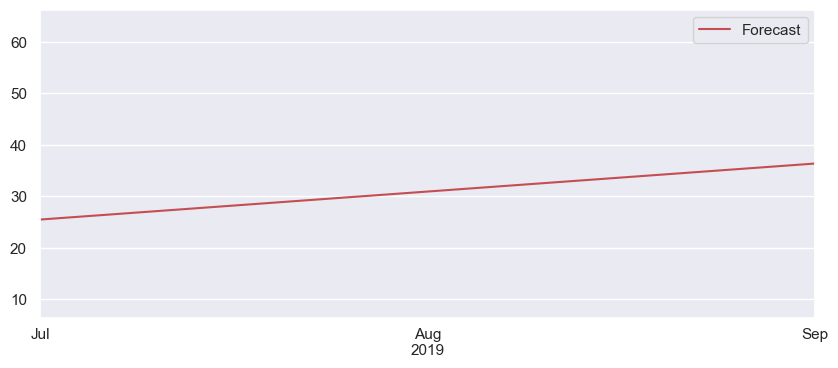

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.fill_between(forecast_index[2:], forecast_ci.iloc[2:, 0], forecast_ci.iloc[2:, 1], alpha=0.1)

legend = ax.legend();

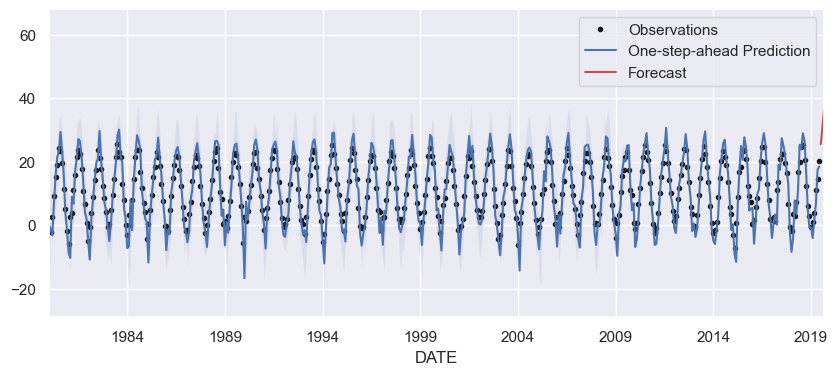

In [9]:
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results
df['TAVG'].plot(ax=ax, style='k.', label='Observations')
predict.predicted_mean.plot(ax=ax, label='One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha=0.05)
predict_index = np.arange(len(predict_ci))
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha=0.1)

forecast.predicted_mean.plot(ax=ax, style='r', label='Forecast')
forecast_ci = forecast.conf_int()
forecast_index = np.arange(len(predict_ci), len(predict_ci) + len(forecast_ci))
ax.fill_between(forecast_index[2:], forecast_ci.iloc[2:, 0], forecast_ci.iloc[2:, 1], alpha=0.1)

legend = ax.legend();